In [17]:
from __future__ import absolute_import, division, print_function
from sklearn.model_selection import train_test_split
from math import sqrt
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import os

## Data Processing

In [2]:
# this should be the path of one region, e.g. data/JAMSTEC2/
datapath = 'data/'
filenames = os.listdir(datapath)
data = []
count = 0.0
for filename in filenames:
    count += 1
    print("Loading {:.2%}".format(count/len(filenames)), end="\r")
    file = open(datapath + filename)
    for line in file:
        features = line.split()
        features = list(map(float, features[:-1]))
        if np.isnan(sum(features)):
            continue
        data.append(features)
    file.close()

In [67]:
data = np.array(data)
# discard column 0, 1, 3, 4, 5
X = data[:, [2]+list(range(6,35))]

# normalize data
X = keras.utils.normalize(X, axis=0, order=2)
y = [int(x==9999) for x in data[:,4]]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

## Building Model

In [68]:
# Hyper-parameters
epochs = 2         # This should be adjusted
batch_size = 64    # The larger the faster
learning_rate = 0.001


In [73]:
class Model_FC:    
    def forward(inputs):
        x = keras.layers.Dense(128, activation=tf.nn.relu)(inputs)
        x = keras.layers.Dense(64, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(32, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(16, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
        return x
    
    def build():
        inputs = keras.layers.Input(shape=(X_train.shape[1],))
        outputs = Model_FC.forward(inputs)
        model = keras.Model(inputs=inputs, outputs=outputs)
        return model

model = Model_FC.build()
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 30)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                1984      
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_66 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_67 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 9         
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
________________________________________________________

## Training

In [74]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weights.hdf5', verbose=0, save_best_only=True)
#model.load_weights('weights.hdf5')
history = model.fit(X_train, y_train, epochs=epochs, class_weight='auto',
                    validation_split=0.2, verbose=1, batch_size=batch_size, 
                    callbacks=[checkpointer])

Train on 2667864 samples, validate on 666967 samples
Epoch 1/2
2667864/2667864 [==============================] - 65s 24us/step - loss: 0.0722 - precision_1: 0.8524 - recall_3: 0.7065 - val_loss: 0.0445 - val_precision_1: 0.9749 - val_recall_3: 0.7651
Epoch 2/2
2667864/2667864 [==============================] - 64s 24us/step - loss: 0.0359 - precision_1: 0.9322 - recall_3: 0.8571 - val_loss: 0.0293 - val_precision_1: 0.9532 - val_recall_3: 0.8918


## Evaluation

In [15]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.epoch, np.sqrt(np.array(history.history['loss'])),
           label='Train Loss')
    plt.plot(history.epoch, np.sqrt(np.array(history.history['val_loss'])),
           label = 'Val loss')
    plt.legend()

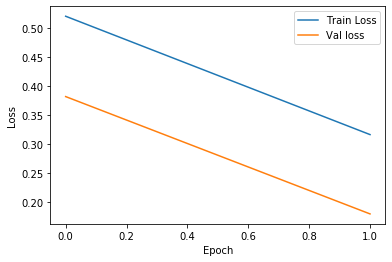

In [18]:
plot_history(history)

In [75]:
[loss, precision, recall] = model.evaluate(X_val, y_val, verbose=0)
print("Validation Loss: {:.3f}".format(loss))
print("Validation Precision: {:.3f}".format(precision))
print("Validation Recall: {:.3f}".format(recall))

Validation Loss: 0.029
Validation Precision: 0.955
Validation Recall: 0.892


In [27]:
y_pred = model.predict(X_val)
# Compare this with y_val to get score